### Imports

In [1]:
from itertools import product

import numpy as np
import pandas as p
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import to_rgba

### Utility functions

In [2]:
def plot_points(points, addnotations = [], **kwargs):
    # plot points
    if len(points):
        plt.scatter(*zip(*points), **kwargs)
    
    # plot addnotations
    for p, text in zip(points, addnotations):
        plt.annotate(text, p, (5, 5), textcoords='offset pixels')

def plot_segments(segments, colors = None, zorder=1, **kwargs):
    
    # handle colors conversion
    if isinstance(colors, list):
        colors = [to_rgba(c) for c in colors]
    elif colors is not None:
        colors = [to_rgba(colors)] * len(segments)
    
    # plot segments using collection for better performance
    plt.gca().add_collection(LineCollection(segments, colors=colors, zorder=zorder, **kwargs))

### Generating random 2d points

In [3]:
def random_points_plane(n, low, high):
    return np.random.uniform(low=low, high=high, size=(n, 2))

def random_points_circle(n, radius, center):
    angles = np.random.uniform(low=0, high=2*np.pi, size=(n))
    points = np.full((n, 2), radius, dtype='d')
    points[:, 0] *= np.cos(angles)
    points[:, 1] *= np.sin(angles)
    points[:, 0] += center[0]
    points[:, 1] += center[1]
    return points

def random_points_line(n, vector, low, high):
    t_min = max((low - vector[0,0]) / (vector[1,0] - vector[0,0]), (low - vector[0,1]) / (vector[1,1] - vector[0,1]))
    t_max = min((high - vector[0,0]) / (vector[1,0] - vector[0,0]), (high - vector[0,1]) / (vector[1,1] - vector[0,1]))
    
    t = np.random.uniform(low=t_min, high=t_max, size=(n, 1))
    return (1-t) * vector[0] + t * vector[1]

#### Examples

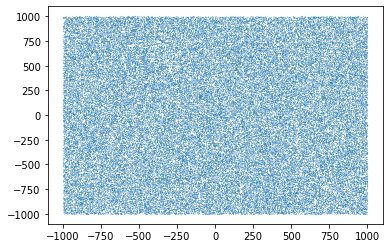

In [4]:
POINTS_A = random_points_plane(10**5, -1000, 1000)
plot_points(POINTS_A, s=0.01)

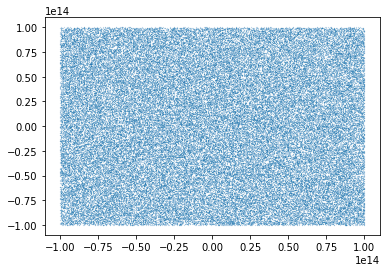

In [5]:
POINTS_B = random_points_plane(10**5, -10**14, 10**14)
plot_points(POINTS_B, s=0.01)

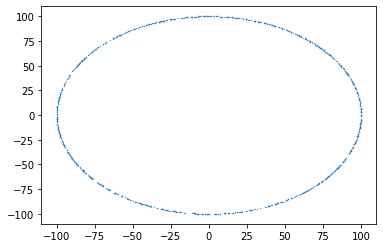

In [6]:
POINTS_C = random_points_circle(1000, 100, (0,0))
plot_points(POINTS_C, s=0.1)

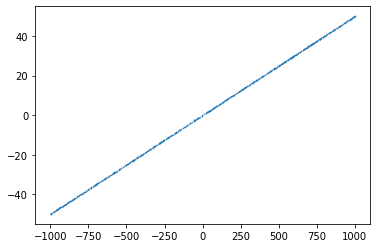

In [7]:
POINTS_D = random_points_line(1000, np.array([[-1.0, 0.0], [1.0, 0.1]]), -1000, 1000)
plot_points(POINTS_D, s=0.1)

### Determining the position of the point relative to the segment

In [8]:
def rpp_det1(a, b, c):
    m = np.ones((3,3))
    m[0, :2] = a
    m[1, :2] = b
    m[2, :2] = c
    return np.linalg.det(m)

def rpp_det2(a, b, c):
    return np.linalg.det(np.vstack((a - c, b - c)))

def rpp_det3(a, b, c):
    return a[0]*b[1] + b[0]*c[1] + c[0]*a[1] - a[0]*c[1] - b[0]*a[1] - c[0]*b[1]
    
def rpp_det4(a, b ,c):
    x = a - c
    y = b - c
    return x[0]*y[1] - x[1]*y[0]

#### Examples

In [9]:
a = np.array([1.3,2.1])
b = np.array([3.6,4.4])
c = [
    np.array([4.5,6.1]),
    np.array([5.9,6.7]),
    np.array([3.5,3.8])
]

,c1,c2,c3
det1,1.84,-1.838529e-15,-1.15
det2,1.84,0.000000e+00,-1.15
det3,1.84,-3.552714e-15,-1.15
det4,1.84,0.000000e+00,-1.15


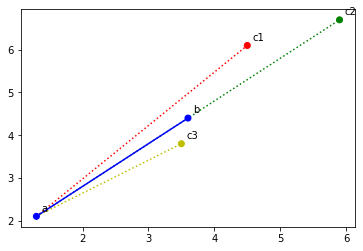

In [10]:
plot_segments([[a,p] for p in c], colors=['r', 'g', 'y'], linestyles='dotted')
plot_segments([[a,b]], colors='b')
plot_points([a,b,*c], c=['b', 'b', 'r', 'g', 'y'], addnotations=['a', 'b', 'c1', 'c2', 'c3'])

results = [[f(a,b,p) for p in c] for f in [rpp_det1,rpp_det2,rpp_det3,rpp_det4]]
p.DataFrame(results, columns=['c1','c2','c3'], index=['det1','det2','det3','det4'])

### Testing `rpp_det*` function 

In [11]:
def split_points_by_rpp(points, a, b, rpp_func, atol=1e-08):
    rpp = np.apply_along_axis(lambda c: rpp_func(a, b, c), 1, points)
    return (
        points[rpp > atol],
        points[np.isclose(rpp, 0.0, atol=atol)],
        points[rpp < -atol]
    )

def collect_test_data(points, a, b, functions, atols):
    data = []
    for func in functions:
        results = []
        for atol in atols:
            results += [len(g) for g in split_points_by_rpp(points, a, b, func, atol)]
        data.append(results)
    
    columns = [f'{t} {a}' for a, t in product(atols, ['left','inline','right'])]
    index = [f.__name__ for f in functions]
    return p.DataFrame(data, columns=columns, index=index)

In [12]:
ab = np.array([[-1.0, 0.0], [1.0, 0.1]])
functions = [rpp_det1, rpp_det2, rpp_det3, rpp_det4]
atols = [1e-13, 1e-12, 1e-11, 1e-10, 1e-09]

#### Points A

In [13]:
collect_test_data(POINTS_A, *ab, functions, atols)

,left 1e-13,inline 1e-13,right 1e-13,left 1e-12,inline 1e-12,right 1e-12,left 1e-11,inline 1e-11,right 1e-11,left 1e-10,inline 1e-10,right 1e-10,left 1e-09,inline 1e-09,right 1e-09
rpp_det1,50102,0,49898,50102,0,49898,50102,0,49898,50102,0,49898,50102,0,49898
rpp_det2,50102,0,49898,50102,0,49898,50102,0,49898,50102,0,49898,50102,0,49898
rpp_det3,50102,0,49898,50102,0,49898,50102,0,49898,50102,0,49898,50102,0,49898
rpp_det4,50102,0,49898,50102,0,49898,50102,0,49898,50102,0,49898,50102,0,49898


#### Points B

In [14]:
collect_test_data(POINTS_B, *ab, functions, atols)

,left 1e-13,inline 1e-13,right 1e-13,left 1e-12,inline 1e-12,right 1e-12,left 1e-11,inline 1e-11,right 1e-11,left 1e-10,inline 1e-10,right 1e-10,left 1e-09,inline 1e-09,right 1e-09
rpp_det1,50003,0,49997,50003,0,49997,50003,0,49997,50003,0,49997,50003,0,49997
rpp_det2,50000,11,49989,50000,11,49989,50000,11,49989,50000,11,49989,50000,11,49989
rpp_det3,50003,0,49997,50003,0,49997,50003,0,49997,50003,0,49997,50003,0,49997
rpp_det4,50001,8,49991,50001,8,49991,50001,8,49991,50001,8,49991,50001,8,49991


#### Points C

In [15]:
collect_test_data(POINTS_C, *ab, functions, atols)

,left 1e-13,inline 1e-13,right 1e-13,left 1e-12,inline 1e-12,right 1e-12,left 1e-11,inline 1e-11,right 1e-11,left 1e-10,inline 1e-10,right 1e-10,left 1e-09,inline 1e-09,right 1e-09
rpp_det1,504,0,496,504,0,496,504,0,496,504,0,496,504,0,496
rpp_det2,504,0,496,504,0,496,504,0,496,504,0,496,504,0,496
rpp_det3,504,0,496,504,0,496,504,0,496,504,0,496,504,0,496
rpp_det4,504,0,496,504,0,496,504,0,496,504,0,496,504,0,496


#### Points D

In [16]:
collect_test_data(POINTS_D, *ab, functions, atols)

,left 1e-13,inline 1e-13,right 1e-13,left 1e-12,inline 1e-12,right 1e-12,left 1e-11,inline 1e-11,right 1e-11,left 1e-10,inline 1e-10,right 1e-10,left 1e-09,inline 1e-09,right 1e-09
rpp_det1,0,1000,0,0,1000,0,0,1000,0,0,1000,0,0,1000,0
rpp_det2,112,750,138,86,807,107,0,1000,0,0,1000,0,0,1000,0
rpp_det3,0,1000,0,0,1000,0,0,1000,0,0,1000,0,0,1000,0
rpp_det4,122,746,132,75,829,96,0,1000,0,0,1000,0,0,1000,0


#### Visualisation

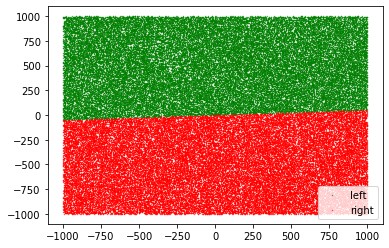

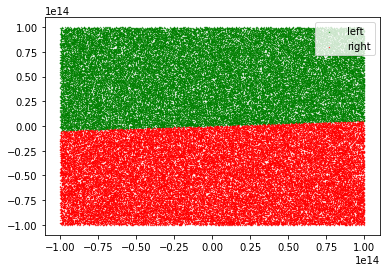

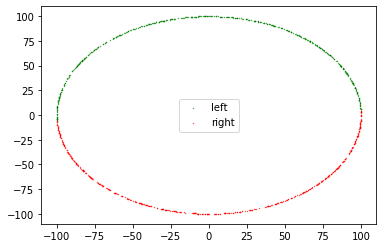

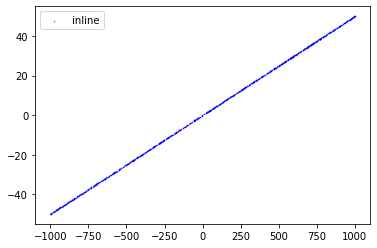

In [17]:
for points in [POINTS_A, POINTS_B, POINTS_C, POINTS_D]:
    left, inline, right = split_points_by_rpp(points, *ab, rpp_det1, atol=1e-10)
    plot_points(left, c='g', s=0.1, label='left')
    plot_points(right, c='r', s=0.1, label='right')
    plot_points(inline, c='b', s=0.1, label='inline')
    plt.legend()
    plt.show()